<a href="https://colab.research.google.com/github/harrisb002/GrainBoundaryDetection/blob/StarDist/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data
- This notebook show how the training data for our model will look like and whether the annotated objects can be appropriately described by star-convex polygons.

- The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install stardist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.1 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap
from stardist.matching import matching_dataset

from skimage import io
import os

np.random.seed(42)
lbl_cmap = random_label_cmap()


Import the data from DataCollection folder

---


In [ ]:
# Get the sorted list of file paths
image_paths = sorted(glob('/content/drive/MyDrive/Grain Boundary Detection/Stardist/data/train/images/*.tif'))
mask_paths = sorted(glob('/content/drive/MyDrive/Grain Boundary Detection/Stardist/data/train/masks/*.tif'))

# Read the images and masks into arrays
X = [io.imread(image_path) for image_path in image_paths]
Y = [io.imread(mask_path) for mask_path in mask_paths]

Load only a small subset

In [ ]:
X, Y = X[:10], Y[:10]

In [ ]:
print("Length of X:", len(X))
print("Length of Y:", len(Y))

Length of X: 10
Length of Y: 10


In [ ]:
i = min(4, len(X)-1)
img, lbl = X[i], Y[i]

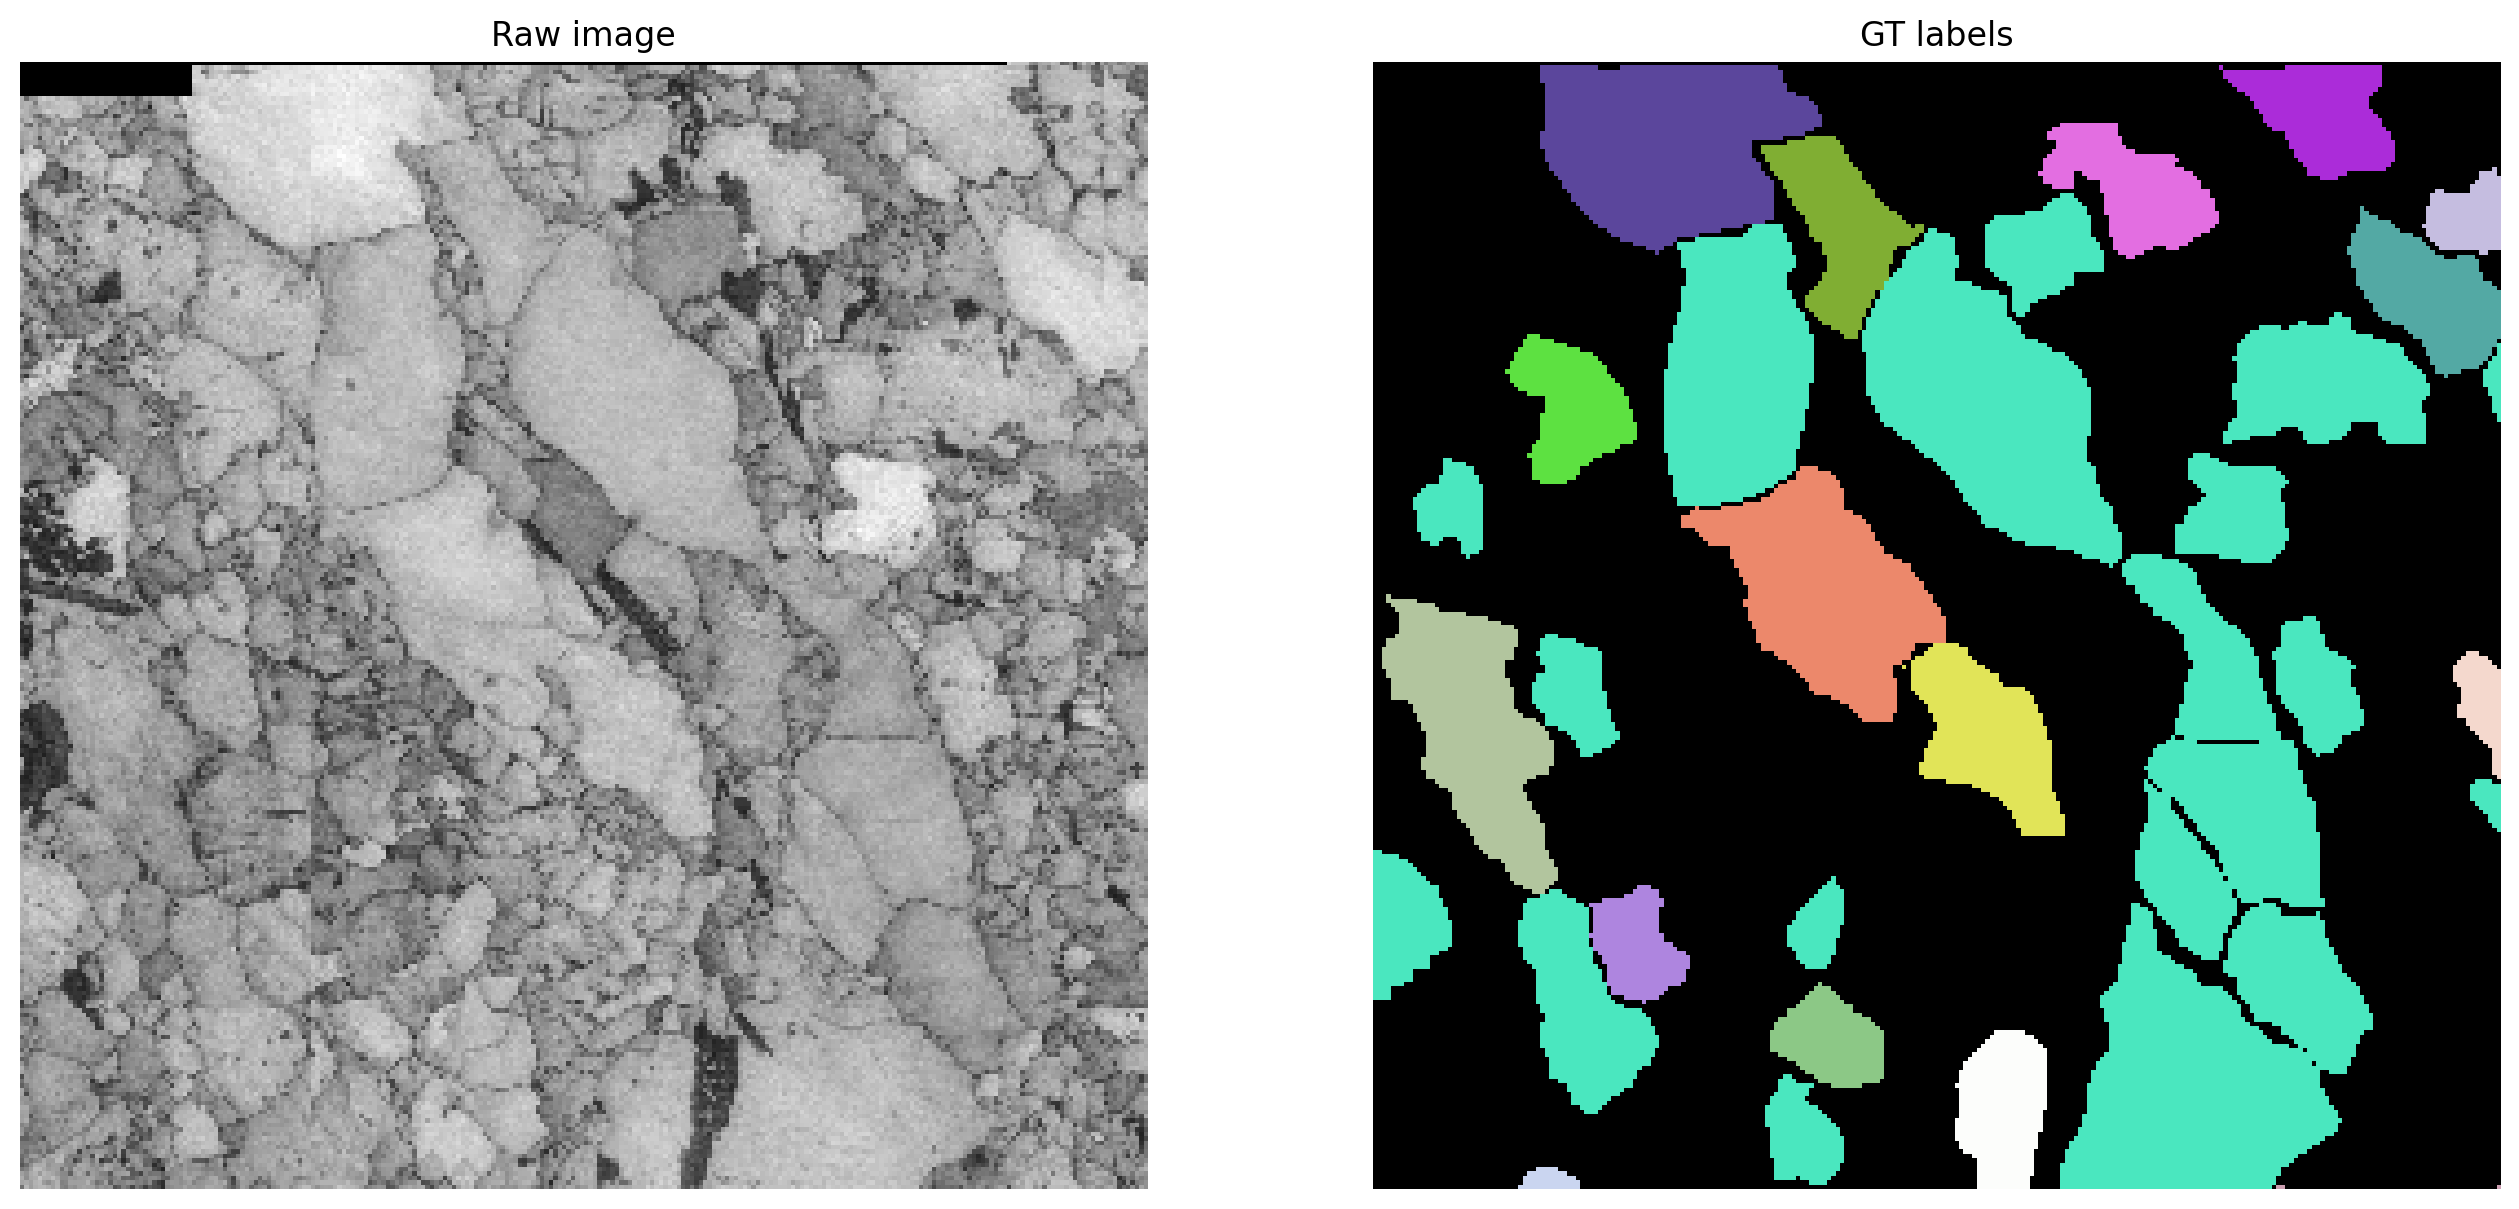

In [ ]:
# Now you can display the images
plt.figure(figsize=(16, 10))
plt.subplot(121); plt.imshow(img, cmap='gray'); plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl, cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
plt.show()

# Fitting ground-truth labels with star-convex polygons

In [ ]:
n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
    mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|██████████| 6/6 [00:34<00:00,  5.76s/it]


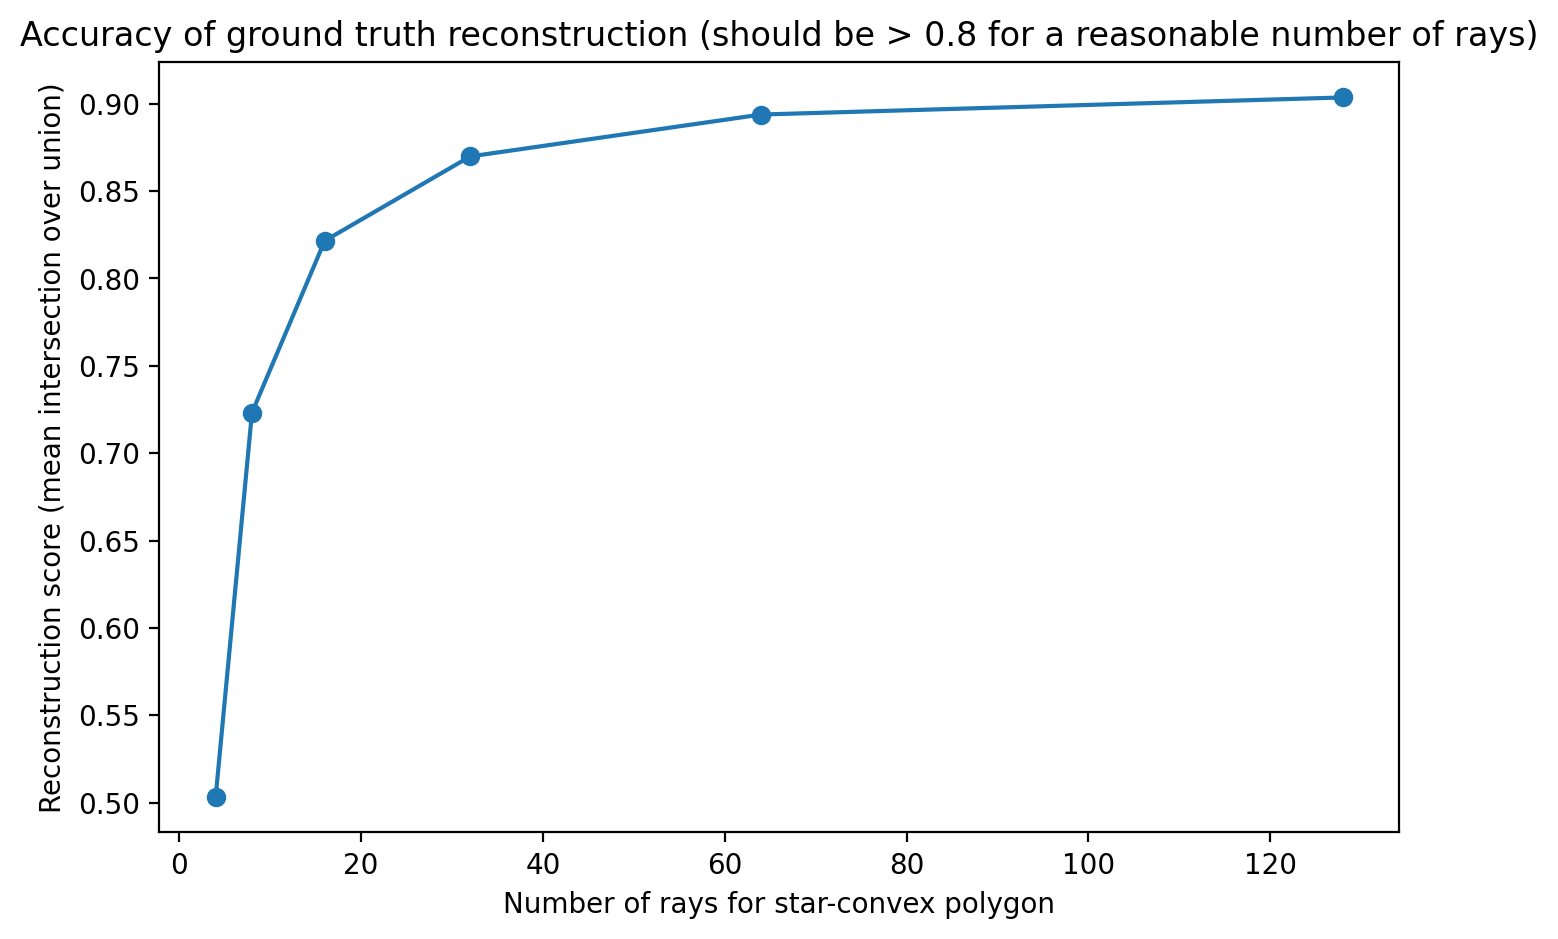

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

## Example image reconstructed with various number of rays

Label image is at index: 4


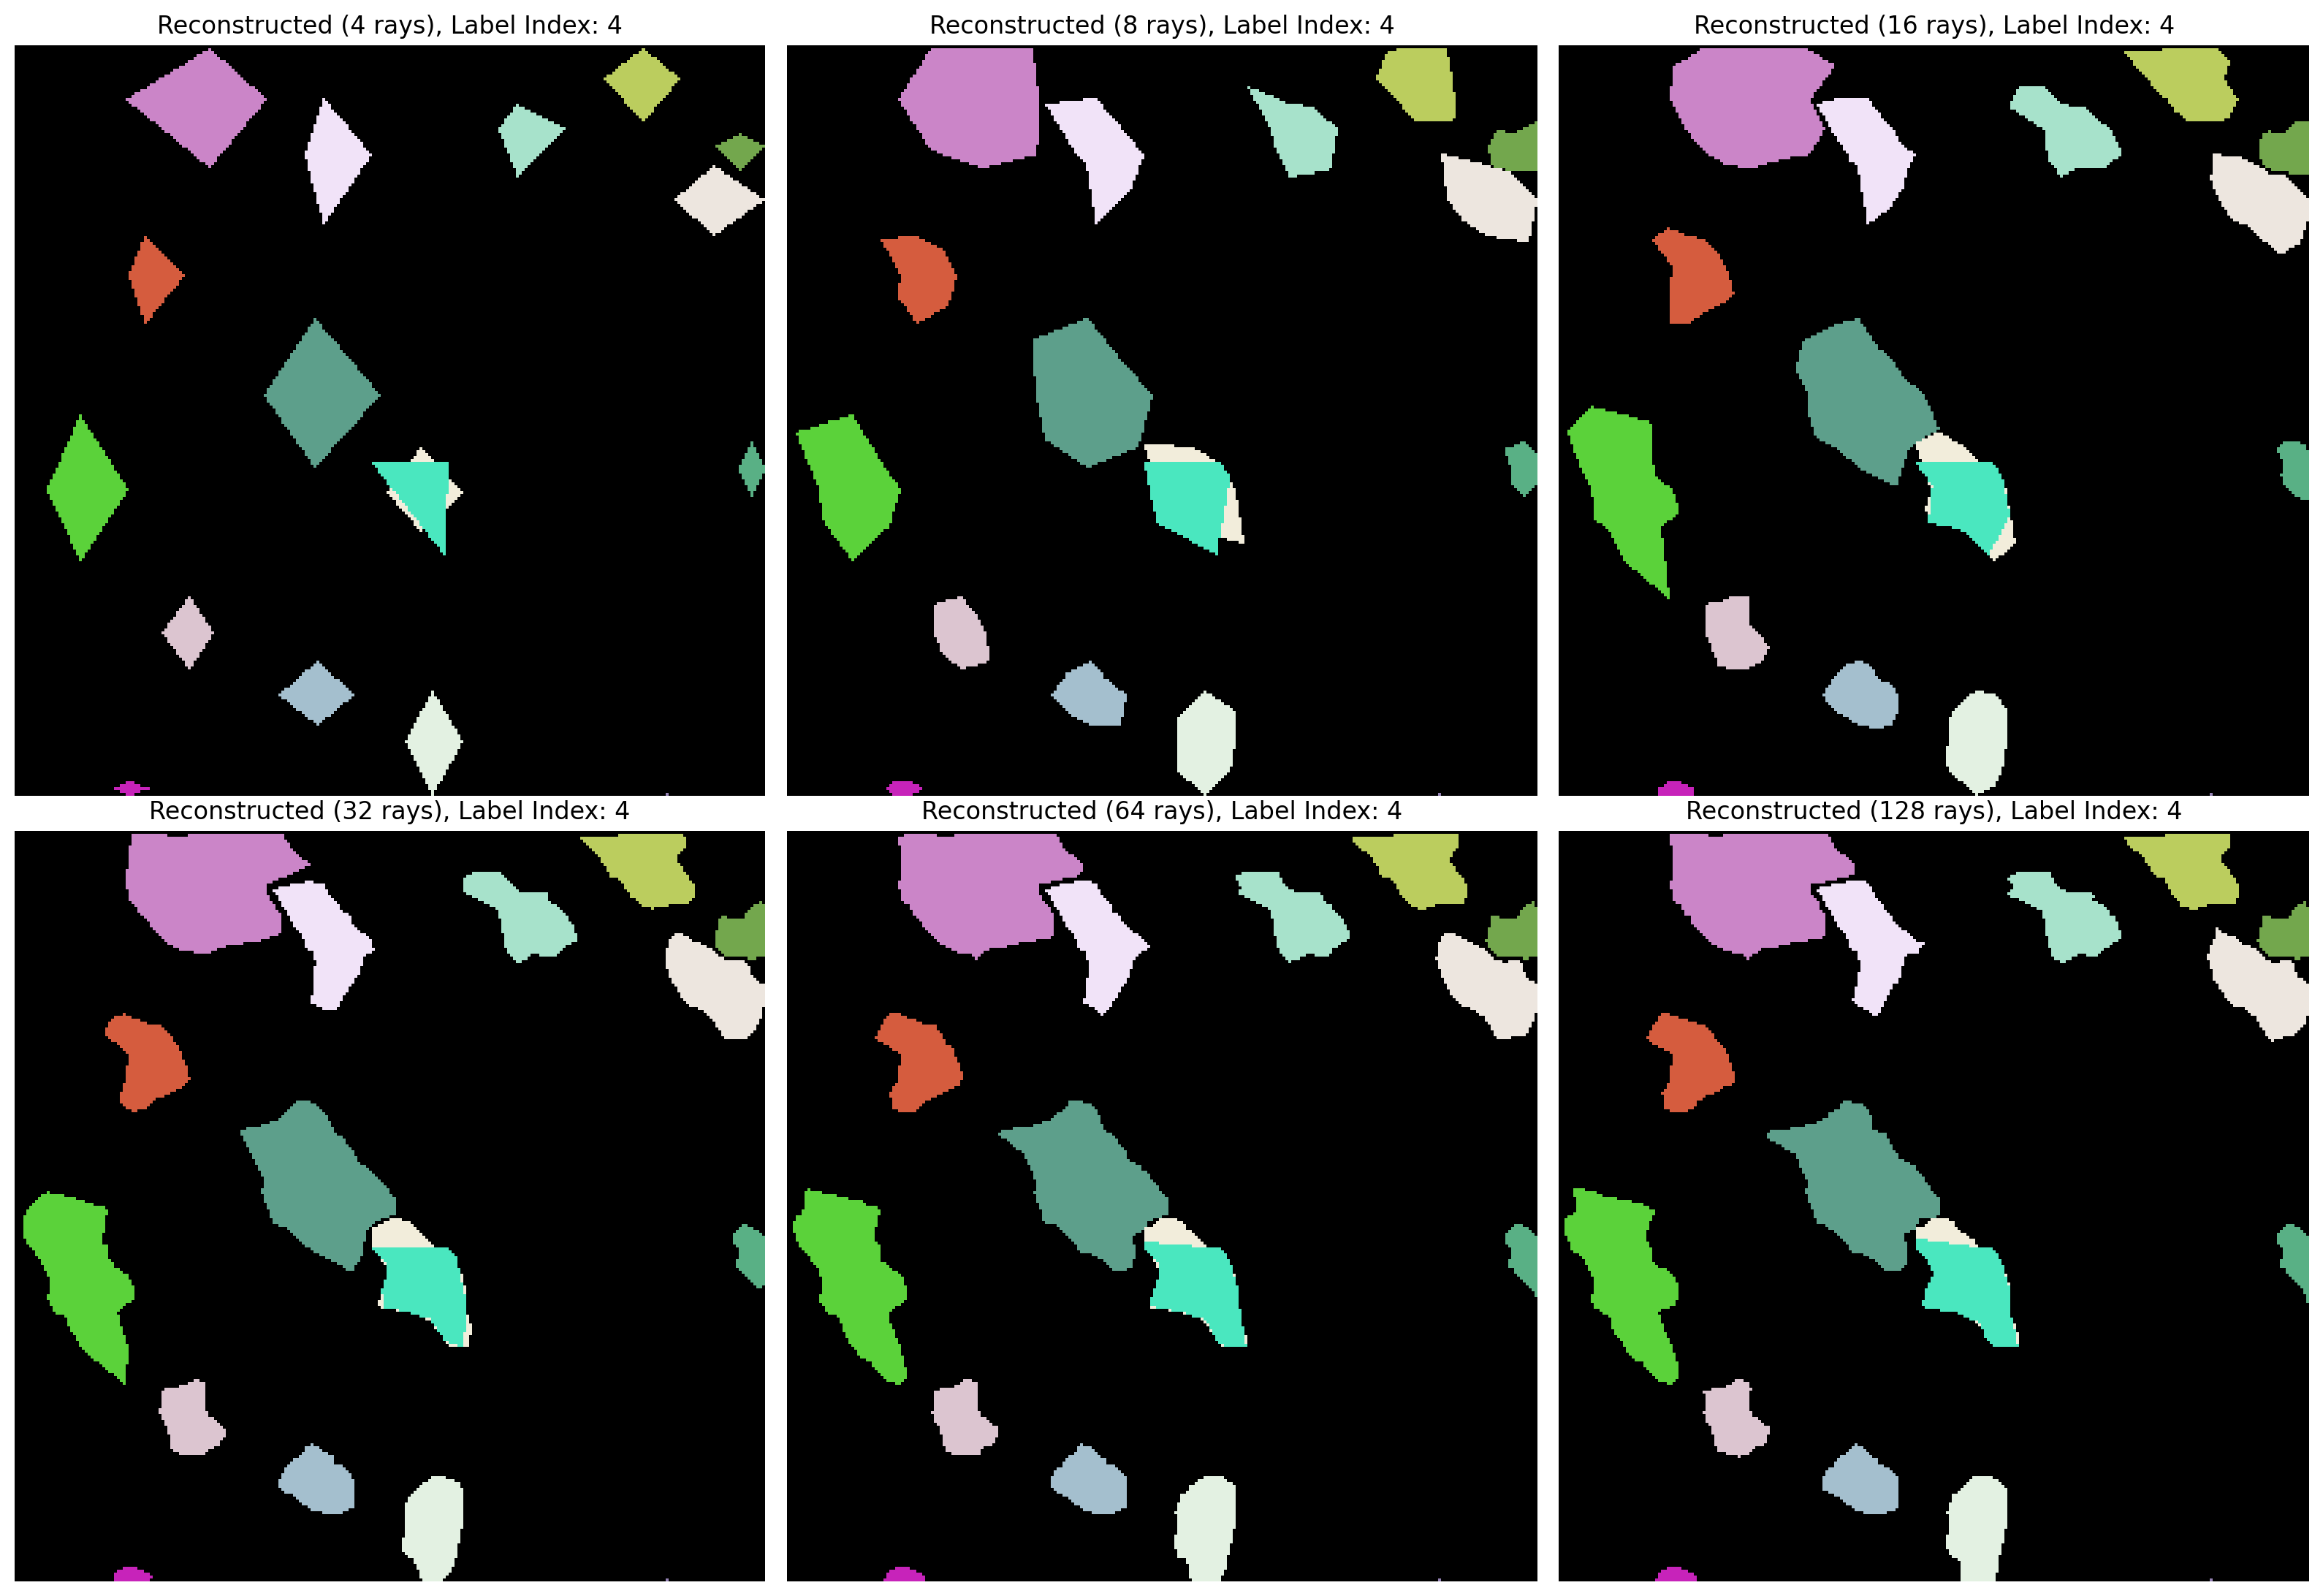

In [ ]:
# Find the index of lbl in Y using array comparison
lbl_index = None
for i, y in enumerate(Y):
    if np.array_equal(lbl, y):
        lbl_index = i
        break

if lbl_index is not None:
    print("Label image is at index:", lbl_index)

    # Plotting code with the found index
    fig, ax = plt.subplots(2, 3, figsize=(16, 11))
    for a, r in zip(ax.flat, n_rays):
        a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
        a.set_title(f'Reconstructed ({r} rays), Label Index: {lbl_index}')
        a.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Label image not found in Y")